# Moist thermodynamics #

This notebook explores the effect of different processes on the thermodynamic structure of the troposphere.  If uses a python thermodynamic libary (aes_thermo).  I try to maintain an updated copy at this link

https://owncloud.gwdg.de/index.php/s/tu8fvhM4klLW6rI



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aes_thermo as  mt
from scipy import interpolate, optimize

!%matplotlib inline
print (mt.Rd,mt.cpd,mt.Rv,mt.sd00)

/bin/sh: line 0: fg: no job control
287.06357820226583 1004.7802489509226 461.5228083134561 6613.82786163544


In [2]:
def Theta(X,x):
    if (x == 'e'):
        Tx = mt.get_theta_e(X[0],X[1],X[2])
        cp = mt.cpd*(1-X[2]) + mt.cpl*X[2]
    if (x == 'l'):
        Tx = mt.get_theta_l(X[0],X[1],X[2])
        cp = mt.cpd*(1-X[2]) + mt.cpv*X[2]
    if (x == 's'):
        Tx = mt.get_theta_s(X[0],X[1],X[2])
        cp = mt.cpd
    return Tx, cp

def T_from_Tx(Tx,P,q,x):
    if (x == 'e'):
        T   = mt.T_from_Te(Tx,P,q)
    if (x == 'l'):
        T   = mt.T_from_Tl(Tx,P,q)
    if (x == 's'):
        T   = mt.T_from_Ts(Tx,P,q)
    return T
    
def X(T,P,q):
    cp = mt.cpd*(1-q) + mt.cpl*q
    return np.asarray([T,P,q])

kind = 's'
P  = 100000

X1 = X(290,P,8.0e-3)
Tx1,cx1 = Theta(X1,kind)

X2 = X(300,P, .0e-3)
Tx2,cx2 = Theta(X2,kind)

qbar   = 0.5*(X1[2] + X2[2])
cbar   = 0.5*(cx1+cx2)
Txbar  = 0.5*(Tx1*cx1 + Tx2*cx2)/cbar
Tbar   = T_from_Tx(Txbar,mt.P0,qbar,kind)
print  (Txbar,Theta(np.asarray([Tbar,P,qbar]),kind)[0])
Tsbar  = mt.get_theta_s(Tbar,mt.P0,qbar)

sbar    = mt.cpd*np.log(Tsbar)
Ts1,cs1 = Theta(X1,'s')
Ts2,cs2 = Theta(X2,'s')
s12     = mt.cpd*np.log(0.5*(Ts1+Ts2))
s1      = mt.cpd*np.log(Ts1)
s2      = mt.cpd*np.log(Ts2)

print ('Kind ',kind,Tbar, cbar, sbar, (s1+s2)*0.5, s12)

s1      = (mt.sv00 + mt.cpv * np.log(X1[0]/298.15) + mt.Rv * np.log(X1[1]/100000.)) * X1[2] + (mt.sd00 + mt.cpd * np.log(X1[0]/298.15) + mt.Rd * np.log(X1[1]/100000.)) * (1-X1[2])
s2      = (mt.sv00 + mt.cpv * np.log(X2[0]/298.15) + mt.Rv * np.log(X2[1]/100000.)) * X2[2] + (mt.sd00 + mt.cpd * np.log(X2[0]/298.15) + mt.Rd * np.log(X2[1]/100000.)) * (1-X2[2])

X3      = X2*1.
X3[2]   = (X1[2]+X2[2])*0.5
X3[0]   = ((mt.cpd * (1-X1[2]) + mt.cpv * X1[2])*X1[0] + (mt.cpd * (1-X2[2]) + mt.cpv * X2[2])*X2[0]) / (2.*(mt.cpd * (1-X3[2]) + mt.cpv * X3[2]))
s3      = (mt.sv00 + mt.cpv * np.log(X3[0]/298.15) + mt.Rv * np.log(X3[1]/100000.)) * X3[2] + (mt.sd00 + mt.cpd * np.log(X3[0]/298.15) + mt.Rd * np.log(X3[1]/100000.)) * (1-X3[2])

print ('T3',X3[0])
print ((s1+s2)*0.5,s3)



#print (2.*np.log(295), np.log(290)+np.log(300))[5793.92859584] [5793.80109024] [5793.81977262]

[302.37057698] [302.37057698]
Kind  s [294.57506207] 1004.7802489509226 [5738.95646613] [5738.92558569] [5738.95646613]
T3 294.9829356935087
6617.739348527668 6617.88419098052


In [3]:
gravity = 9.8076
Rstar   = 8.31446261815324
P0      = 100000.  # Standard Pressure [Pa]
T0      = 273.15   # Standard Temperature [K]
#
# Based on Park et al (2004) Meteorlogia, O2 levels are declining as CO2 levels rise, but at a tiny arte.
#
x_ar  = 9.332e-3
x_o2  = 0.20944 
x_n2  = 0.78083  
x_co2 = 0.415e-3
#
# Based on Chase (1998) J Phys Chem Ref Data
#
m_ar  = 39.948
m_o2  = 15.9994  * 2
m_n2  = 14.0067 * 2
m_co2 = 44.011
m_h2o = 18.01528

cp_ar  = 20.786  # 298.15K
cp_o2  = 29.376  # 298.15K or 29.126 @ 200K
cp_n2  = 29.124  # 298.15K or 29.107 @ 200K
cp_co2 = 37.129  # 298.15K or 32.359 @ 200K
cp_h2o = 33.349 + (33.590 - 33.349)/98.15 * (T0-200) # Interpolated to T0 from Chase values (but not used)

s0_ar  = 154.845  # 298.15K
s0_o2  = 205.147  # 298.15K 
s0_n2  = 191.609  # 298.15K 
s0_co2 = 213.795  # 298.15K
s0_h2o = 188.854  # 298.15

md    = x_ar*m_ar + x_o2*m_o2 + x_n2*m_n2 + x_co2*m_co2 # molar mass of dry air
q_ar  = x_ar *m_ar /md
q_o2  = x_o2 *m_o2 /md
q_n2  = x_n2 *m_n2 /md
q_co2 = x_co2*m_co2/md

Rd  = (Rstar/md)*(x_ar+x_o2+x_n2+x_co2) * 1000.  #J/kg/K
cpd = (   1./md)*(x_ar*cp_ar + x_o2*cp_o2 + x_n2*cp_n2 + x_co2*cp_co2) *1000.  #J/kg/K
sd00= (   1./md)*(x_ar*s0_ar + x_o2*s0_o2 + x_n2*s0_n2 + x_co2*s0_co2) * 1000.  + cpd * np.log(T0/298.15)  # Dry air entropy at P0, T0


cpv     = 1865.01   # IAPWS97 at 273.15 , for this we could use the Chase values, but they are closer to 1861
cpl     = 4219.32   # '' 
cpi     = 2096.70   # ''
lv0     = 2500.93e3 # ''
lf0     =  333.42e3 # ''
Rv      = (Rstar/m_h2o) *1000.  #J/kg/K
sv00    = (s0_h2o/m_h2o)*1000.  + cpv * np.log(T0/298.15)

eps1     = Rd/Rv
eps2     = Rv/Rd -1.

PvC     = 22.064e6 # Critical pressure [Pa] of water vapor
TvC     = 647.096  # Critical temperature [K] of water vapor
TvT     = 273.16   # Triple point temperature [K] of water
PvT     = 611.655

print (sd00,sv00,Rd,mt.sd00,mt.sv00,mt.Rd)



6613.311399028216 10319.660586746879 287.04116189401907 6613.82786163544 10319.660586746879 287.06357820226583


## Calculating $T$ (or $T_\mathrm{v}$) for different thermodynamic processes ##

We start with a differential form, $\mathrm{d}X$ that allows us to construct how temperature changes with pressure following different processes.  The form we construct is similar to $\theta_\mathrm{l}$ allows for a saturated isentrope allowing only for a liquid phase, a saturated isentrope assuming only a solidphase, whereby the saturated vapor pressure over ice is set to that over water at temperatures above 273.15 K.  We also calculate the pseudo adiabats, one allowing only a liquid phase, and another that transitions to the ice-phase at temperatures below 273.15 K, and differs from the former by the additional fusion enthalpy.  The true reversible isentrope would follow the saturated liquid phase isentrope at temperatures above the triple point and the saturated ice-phase isentrope at temperatures below the triple point.

The integration follows by virtue of $\mathrm{d}X = 0$ and $X=X(T,P,q_\mathrm{t}),$ hence we calculate $\partial X/\partial T$ and $\partial X/ \partial P$ following Stevens and Siebesma (2020), and integrate 
$$ \mathrm{d}X =  \frac{\partial X}{\partial T} \mathrm{d}T + \frac{\partial X}{\partial P} \mathrm{d}P  = 0$$ to solve for $T$ given $P.$  That is $$ T(P) = T(P_0) - \int_{P_0}^P \left(\frac{\partial X}{\partial T} \right)^{-1} \frac{\partial X}{\partial P} \mathrm{d}P$$

In [4]:
def dX(TK,PPa,qt,formula='isentrope') :

    if (formula == 'ice-isentrope' or formula == 'pseudo-ice'):
        Psat   = mt.es(TK,state='mxd')
    else:
        Psat   = mt.es(TK)

    qs     = (Psat/(PPa-Psat)) * mt.eps1 * (1-qt)
    if (qs < qt):
        qc = 0.
        if (formula[:6] == 'pseudo'):
            qd = 1.-qs
        else:
            qc = qt-qs
            qd = 1.-qt
 
        if (formula == 'ice-isentrope'):
            cp     = qd * mt.cpd + qs * mt.cpv + qc * mt.cpi
            lv     = mt.phase_change_enthalpy(TK) + mt.phase_change_enthalpy(TK,fusion=True)
        elif (formula == 'pseudo-ice' and TK < 273.15):
            cp     = qd * mt.cpd + qs * mt.cpv + qc * mt.cpl
            lv     = mt.phase_change_enthalpy(TK) + mt.phase_change_enthalpy(TK,fusion=True)
        else:
            cp     = qd * mt.cpd + qs * mt.cpv + qc * mt.cpl
            lv     = mt.phase_change_enthalpy(TK)
            
        R      = qd * mt.Rd + qs * mt.Rv
        vol    = R * TK/ PPa

        beta_P = R/(qd*mt.Rd)
        if (formula[:6] == 'pseudo'):
            beta_P = R/mt.Rd

        beta_T = beta_P * lv/(mt.Rv * TK) 
        dX_dT  = cp + lv * qs * beta_T/TK
        dX_dP  = vol * ( 1.0 + lv * qs * beta_P/(R*TK))
    else:
        cp     = mt.cpd + qt * (mt.cpv - mt.cpd)
        R      = mt.Rd  + qt * (mt.Rv  - mt.Rd)
        vol    = R * TK/ PPa
        dX_dT  = cp 
        dX_dP  = vol

    return dX_dT, dX_dP;

### Comparing the different temperature changes ###

Here we simply calculate and plot some of the different temperature pressure diagrams associated with the different processes.  We use the notation of $\theta_\mathrm{e}$ to denote the saturated isentope and the tilde for the pseudo adiabat.   For the first comparision of $\theta_\mathrm{e}$  and $\theta_\mathrm{e,ice}$ we show by the grey line the $T=273.15~\mathrm{K}$ isotherm, at the pressure levels where it would connect the solid and liquid phase isentropes. 

To get these results we numerically integrate along a constant $X$ which yields $T(P)$.  Fot his we use a numerical ode solver form scipy, here the lsoda solver, but other solvers also work similarly well.  These end up being more efficient than a simple integration using an Euler forward method.

In [5]:
from scipy.integrate import ode

def integrate_dTdP(T0,P0,P1,dP,qt,formula='isentrope'):
    def f(P, T, qt):
        dX_dT, dX_dP = dX(T,P,qt,formula)
        return (dX_dP/dX_dT)

    r = ode(f).set_integrator('lsoda',atol=0.0001)
    r.set_initial_value(T0, P0).set_f_params(qt)
    t1 = P1
    dt = dP
    Te = []
    Tx = []
    Px = []

    while r.successful() and r.t > t1:
        r.integrate(r.t+dt)
        Tx.append(r.y[0])
        Px.append(r.t)
        
    return (np.array(Tx),np.array(Px))

qt      = 17.e-3
Tx1, Px = integrate_dTdP(300.,101000.,15000.,-100.,qt)
Tx2, Px = integrate_dTdP(300.,101000.,15000.,-100.,qt,formula='ice-isentrope')
Tx3, Px = integrate_dTdP(300.,101000.,15000.,-100.,qt,formula='pseudo')
Tx4, Px = integrate_dTdP(300.,101000.,15000.,-100.,qt,formula='pseudo-ice')

5.29783904057273
95.67919319725112


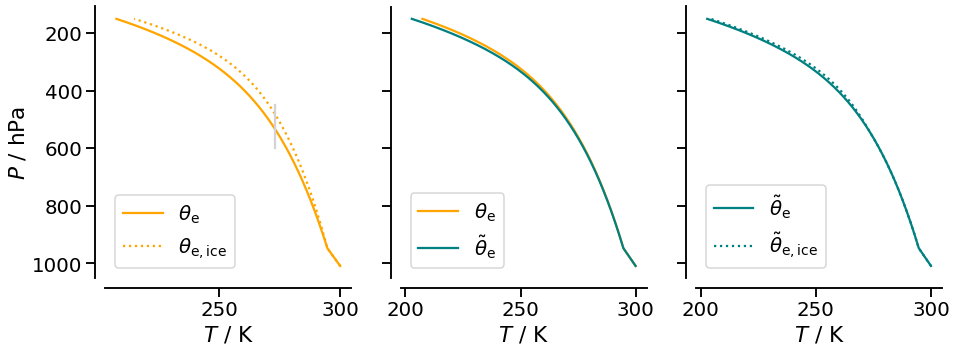

In [20]:
print (9.81/1.005 - (Tx1[90]-Tx1[101])/0.095679)
print ((Tx1[0]-Tx1[11])*1005/9.81)

fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,3,1)
ax1.set_xlabel('$T$ / K')
ax1.set_ylabel('$P$ / hPa')
plt.plot(Tx1,Px/100.,c='orange',label='$\\theta_\mathrm{e}$')
plt.plot(Tx2,Px/100.,c='orange',ls='dotted',label='$\\theta_\mathrm{e,ice}$')
plt.plot([273.15,273.15],[600,450], c='lightgrey')
plt.gca().invert_yaxis()
plt.legend(loc="lower left")

ax2 = plt.subplot(1,3,2)
ax2.set_xlabel('$T$ / K')
ax2.set_yticklabels([])
plt.plot(Tx1,Px,c='orange',label='$\\theta_\mathrm{e}$')
plt.plot(Tx3,Px,c='teal',label='$\\tilde{\\theta}_\mathrm{e}$')
plt.gca().invert_yaxis()
plt.legend(loc="lower left")

ax3 = plt.subplot(1,3,3)
ax3.set_xlabel('$T$ / K')
ax3.set_yticklabels([])
plt.plot(Tx3,Px/100.,c='teal',label='$\\tilde{\\theta}_\mathrm{e}$')
plt.plot(Tx4,Px/100.,c='teal',ls='dotted',label='$\\tilde{\\theta}_\mathrm{e,ice}$')
plt.gca().invert_yaxis()
plt.legend(loc="lower left")

sns.set_context("talk", font_scale=1.2)
sns.despine(offset=10)

### 1.2 Temperature Differences ###

The Temperature differences show the expected behavior.  Ice has a substantial effect on the saturated isentrope, whereby here only the differences at temperatures below the triple point temperature are relevant, i.e., below about 525 hPa.  Otherwise the differences between the saturated isentrope and the pseudo adiabat are a few kelvin in the upper troposphere, and the effect of ice processes on the pseudo adiabat contribute also a couple of kelvin near 300 hPa.

In [ ]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,1,1)
ax1.set_xlabel('$T$ / K')
ax1.set_ylabel('$P$ / hPa')
plt.plot(Tx2-Tx1,Px/100.,c='teal',label='$\\theta_\mathrm{e,ice} - \\theta_\mathrm{e}$')
plt.plot(Tx1-Tx3,Px/100.,c='grey',label='$\\theta_\mathrm{e} - \\tilde{\\theta}_\mathrm{e}$')
plt.plot(Tx4-Tx3,Px/100.,c='orange',label='$\\tilde{\\theta}_\mathrm{e,ice} - \\tilde{\\theta}_\mathrm{e}$')
plt.gca().invert_yaxis()
plt.legend(loc="lower right")

sns.set_context("talk", font_scale=1.2)
sns.despine(offset=10)

### Effects on Density ###

We repeat the above exercise but for the density temperature, $T_\rho = T(1+\epsilon_2 q_\mathrm{v} - q_\mathrm{c})$ including $q_\mathrm{c}$ in a manner consistent with the process yielding $T.$  What we find is that (as shown by the Teal curve) the effect of condensate loading increasingly compensates the compositional contribution to $T_\rho$ from water vapor, so that at pressures less than about 700 hPa it increasingly dominates.   The grey curve compares the isentrope to the pseudo-adiabat, and shows that slower reduction in temperature of the former increasingly offests the effect of the condensate, so that its density temperature is higher in the upper troposphere.  This makes sense because even if all of the vapor (in this case 17 g/kg) is converted to loading it makes a contribution that multiplies an increasingly small temperature, so that at 200K this corresponds to a reduction of 200(1-0.017) or about 4K.  At colder temperatures the reduction is propotionally less, but the temperature difference between the saturated isentrope and the pseudo-adiabat is less. 


In [ ]:
Trho1   = np.zeros(len(Px))
Trho3   = np.zeros(len(Px))

for i,x in enumerate(Px):
    Psat = mt.es(Tx1[i])
    qs = (Psat/(x-Psat)) * (mt.Rd/mt.Rv) * (1-qt)
    qv = np.min([qt,qs])
    Trho1[i] = Tx1[i]*(1 + mt.eps2 * qv - (qt-qv))

    Psat = mt.es(Tx3[i])
    qs = (Psat/(x-Psat)) * (mt.Rd/mt.Rv) * (1-qt)
    qv = np.min([qt,qs])
    Trho3[i] = Tx3[i]*(1 + mt.eps2 * qv)

    
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,1,1)
ax1.set_xlabel('$T$ / K')
ax1.set_ylabel('$P$ / hPa')
plt.plot(Trho1-Tx1,Px/100.,c='teal',label='$T_\\rho - T$')
plt.plot(Trho1-Trho3,Px/100.,c='grey',label='$T_\\rho - \\tilde{T}_\\rho$')

plt.gca().invert_yaxis()
plt.legend(loc="center right")

sns.set_context("talk", font_scale=1.2)
sns.despine(offset=10)

### Consistency Checks ###

Here we plot $\theta_\mathrm{e}$, $\theta_\mathrm{l}$, and $\theta_s$ calculated from the temperature, pressure and $q_\mathrm{t}$ profiles.   These should, if properly defined, be constant.  They are, almost exactly, but the very small deviations that become apparent may be due to numerical precisions issues in the integration, or some small and lingering inconsistency in the formulation that I have failed to identify.

We can also compare the psuedo adiabatic temperature increase with the formula from Bolton.  For this the differences (O(1K)) are substantial.

In [ ]:
xfld = np.zeros((len(Px),4))

for i,x in enumerate(Px):
    xfld[i,0] = mt.get_theta_e(Tx1[i],x,qt)
    xfld[i,1] = mt.get_theta_e(Tx3[i],x,qt,formula='bolton')

fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
ax1.set_xlabel('$\\theta_\mathrm{e}, \\tilde{\\theta}_\mathrm{e}$ / K')
ax1.set_ylabel('$P$ / hPa')
plt.plot(xfld[:,0]-xfld[0,0],Px/100.,c='teal',label='$\\Delta \\theta_\mathrm{e}$')
plt.plot(xfld[:,1]-xfld[0,1],Px/100.,c='orange',label='$\\Delta \\tilde{\\theta}_\mathrm{e}$')

plt.gca().invert_yaxis()
plt.legend(loc="lower left")

for i,x in enumerate(Px):
    xfld[i,1] = mt.get_theta_l(Tx1[i],x,qt)
    xfld[i,3] = mt.get_theta_s(Tx1[i],x,qt)

ax2 = plt.subplot(1,2,2)
ax2.set_xlabel('mK')
ax2.set_yticklabels([])
plt.plot((xfld[:,0]-xfld[0,0])*1000.,Px/100.,c='teal',label='$\\Delta \\theta_\mathrm{e}$')
plt.plot((xfld[:,1]-xfld[0,1])*1000.,Px/100.,c='dodgerblue',label='$\\Delta \\theta_\mathrm{l}$')
plt.plot((xfld[:,3]-xfld[0,3])*1000.,Px/100.,c='orange',ls='dashed',label='$\\Delta \\theta_s$')

plt.gca().invert_yaxis()
plt.legend(loc="lower left")

sns.set_context("talk", font_scale=1.2)
sns.despine(offset=10)
fig.savefig('thetas-consistency.pdf')

In [ ]:
fig = plt.figure(figsize=(6,6))

ax2 = plt.subplot(1,1,1)
ax2.set_xlabel('mK')
ax1.set_ylabel('$P$ / hPa')
plt.plot((xfld[:,0]-xfld[0,0])*1000.,Px/100.,c='orange',label='$\\Delta \\theta_\mathrm{e}$')
plt.plot((xfld[:,1]-xfld[0,1])*1000.,Px/100.,c='teal',label='$\\Delta \\theta_\mathrm{l}$')
plt.plot((xfld[:,3]-xfld[0,3])*1000.,Px/100.,c='dodgerblue',ls='dashed',label='$\\Delta \\theta_s$')

plt.gca().invert_yaxis()
plt.legend(loc="lower left")
plt.tight_layout()

sns.set_context("talk", font_scale=1.2)
sns.despine(offset=10)
fig.savefig('thetas-consistency.pdf')

### Dependence of $\theta_e$ on $q_t$ ###

### Solving for $T$ from $T_\rho$ and comparing with data###

Here I take to temperature profiles composited from the DYAMOND ICON simulations for a wet 99.999 percentile sounding and a dry sounding.  These we then use to look at what processes determine what I call the master temperature profile, i.e., the temperature profile in the convecting regions that is communicated through the tropical atmosphere.

In [ ]:
Twet = np.array([
    223.9353 , 221.97095, 220.03784, 218.19221, 216.31929, 214.27661,
    211.73238, 208.92947, 206.17117, 203.89218, 202.05592, 200.44272,
    198.63155, 196.21927, 194.47081, 195.16386, 197.48691, 200.50444,
    203.81912, 207.28535, 210.82382, 214.43098, 218.06685, 221.70439,
    225.32275, 228.9053 , 232.43118, 235.8637 , 239.20024, 242.42961,
    245.54013, 248.53214, 251.42017, 254.20903, 256.89557, 259.48453,
    261.9759 , 264.38116, 266.70425, 268.95264, 271.08478, 273.0942 ,
    274.92133, 276.79697, 278.5961 , 280.27567, 281.83926, 283.30765,
    284.69043, 285.99323, 287.22113, 288.37936, 289.47232, 290.50528,
    291.48358, 292.41122, 293.28616, 294.0999 , 294.83893, 295.48620,
    296.02863, 296.47165, 296.83948, 297.22357, 297.66333])

Pwet = np.array([
     1781.3881,   2127.0454,   2521.3892,   2965.2852,   3458.2715,
     4001.646 ,   4597.039 ,   5246.1895,   5949.923 ,   6707.3438,
     7515.943 ,   8372.736 ,   9275.428 ,  10223.398 ,  11213.994 ,
    12235.951 ,  13273.557 ,  14314.763 ,  15366.591 ,  16440.645 ,
    17551.559 ,  18717.012 ,  19938.434 ,  21217.395 ,  22555.648 ,
    23955.1   ,  25417.795 ,  26946.035 ,  28542.363 ,  30209.469 ,
    31950.23  ,  33767.75  ,  35665.18  ,  37645.79  ,  39712.992 ,
    41870.387 ,  44121.695 ,  46470.805 ,  48921.7   ,  51478.516 ,
    54104.145 ,  56747.926 ,  59396.582 ,  62041.99  ,  64675.426 ,
    67288.7   ,  69873.65  ,  72421.9   ,  74924.74  ,  77373.4   ,
    79758.9   ,  82072.14  ,  84303.92  ,  86444.89  ,  88485.586 ,
    90416.375 ,  92227.414 ,  93908.73  ,  95449.89  ,  96839.95  ,
    98067.    ,  99117.28  ,  99973.836 , 100613.055 , 100989.66  ])

Qwet = np.array([
    2.675785e-06, 2.653257e-06, 2.639634e-06, 2.634951e-06, 2.638471e-06,
    2.649419e-06, 2.671635e-06, 2.722334e-06, 2.832603e-06, 3.010935e-06,
    3.215084e-06, 3.322613e-06, 3.304213e-06, 3.132450e-06, 3.003545e-06,
    3.306731e-06, 4.431343e-06, 6.642379e-06, 1.031196e-05, 1.604714e-05,
    2.473562e-05, 3.774666e-05, 5.679549e-05, 8.410055e-05, 1.224644e-04,
    1.757509e-04, 2.497731e-04, 3.527200e-04, 4.911225e-04, 6.678019e-04,
    8.902289e-04, 1.161963e-03, 1.485134e-03, 1.860150e-03, 2.291250e-03,
    2.778659e-03, 3.313594e-03, 3.888310e-03, 4.490240e-03, 5.116668e-03,
    5.753872e-03, 6.392588e-03, 6.993116e-03, 7.623885e-03, 8.274390e-03,
    8.951828e-03, 9.632755e-03, 1.030219e-02, 1.095124e-02, 1.157832e-02,
    1.218259e-02, 1.276330e-02, 1.332142e-02, 1.385734e-02, 1.437104e-02,
    1.486405e-02, 1.533483e-02, 1.577741e-02, 1.617590e-02, 1.651940e-02,
    1.681609e-02, 1.709637e-02, 1.738570e-02, 1.766170e-02, 1.801199e-02])

Tdry = np.array([
    260.46118, 258.63837, 255.8278 , 251.66296, 247.25632, 242.86287,
    238.7334 , 235.24545, 232.37387, 230.01653, 227.97017, 226.12338,
    224.44499, 222.37727, 220.10141, 218.00972, 216.08081, 214.18835,
    212.19333, 210.03035, 207.1936 , 203.98264, 200.97385, 198.6071 ,
    197.285  , 196.89725, 197.44398, 198.81459, 200.74696, 203.02396,
    205.48637, 208.06682, 210.85538, 213.86523, 217.0021 , 220.21277,
    223.46024, 226.73601, 230.04068, 233.36826, 236.69199, 239.98233,
    243.23015, 246.4296 , 249.54622, 252.53671, 255.41533, 258.21182,
    260.9037 , 263.49518, 266.03485, 268.47684, 270.7939 , 272.96356,
    274.96674, 276.79706, 278.5634 , 280.32187, 282.00894, 283.64075,
    285.23346, 286.68976, 287.80414, 288.41498, 288.44867, 288.2182 ,
    288.21365, 288.74942, 289.6866 , 290.72845, 291.8448 , 292.96866,
    294.00327, 294.89948, 295.63406, 296.19107, 296.5726 ])

Pdry = np.array([
    141.82285,    179.46115,    225.8453 ,    282.9698 ,    353.243  ,
    439.3996 ,    544.55994,    672.13464,    825.7498 ,   1009.26807,
    1226.8136 ,   1482.7734 ,   1781.594  ,   2126.512  ,   2520.2896 ,
    2964.1074 ,   3457.401  ,   4001.0703 ,   4595.8213 ,   5242.242  ,
    5941.6104 ,   6695.758  ,   7504.999  ,   8367.091  ,   9276.7705 ,
    10226.591  ,  11207.969  ,  12211.555  ,  13228.347  ,  14250.45   ,
    15286.276  ,  16347.967  ,  17450.18   ,  18610.117  ,  19828.947  ,
    21108.135  ,  22449.408  ,  23854.576  ,  25325.535  ,  26864.16   ,
    28472.465  ,  30152.693  ,  31907.277  ,  33738.805  ,  35650.07   ,
    37644.336  ,  39725.1    ,  41895.926  ,  44160.445  ,  46522.6    ,
    48986.246  ,  51555.383  ,  54192.883  ,  56847.95   ,  59507.273  ,
    62163.582  ,  64808.98   ,  67434.64   ,  70031.65   ,  72591.17   ,
    75104.195  ,  77561.9    ,  79956.48   ,  82281.22   ,  84529.96   ,
    86695.2    ,  88766.5    ,  90730.69   ,  92574.266  ,  94284.92   ,
    95851.39   ,  97262.33   ,  98505.93   ,  99568.93   , 100434.836  ,
    101080.55   , 101460.92   ])


Qdry = np.array([
    3.248840e-06, 3.216901e-06, 3.173897e-06, 3.116910e-06, 3.054899e-06,
    3.004614e-06, 2.968617e-06, 2.941603e-06, 2.915867e-06, 2.880306e-06,
    2.831446e-06, 2.763737e-06, 2.691604e-06, 2.622797e-06, 2.574177e-06,
    2.552536e-06, 2.546951e-06, 2.549817e-06, 2.563278e-06, 2.589809e-06,
    2.637191e-06, 2.734801e-06, 2.932778e-06, 3.241792e-06, 3.620764e-06,
    4.022001e-06, 4.414107e-06, 4.910287e-06, 5.685483e-06, 6.925651e-06,
    8.815266e-06, 1.150364e-05, 1.507771e-05, 1.948587e-05, 2.502891e-05,
    3.231415e-05, 4.203726e-05, 5.449402e-05, 6.963828e-05, 8.651965e-05,
    1.041388e-04, 1.225337e-04, 1.410077e-04, 1.571900e-04, 1.739966e-04,
    1.960605e-04, 2.235830e-04, 2.576729e-04, 3.022493e-04, 3.610218e-04,
    4.288332e-04, 5.132451e-04, 6.098776e-04, 7.398597e-04, 9.299355e-04,
    1.195684e-03, 1.505343e-03, 1.819583e-03, 2.139176e-03, 2.443166e-03,
    2.723889e-03, 3.043162e-03, 3.573373e-03, 4.478660e-03, 5.825936e-03,
    7.405198e-03, 8.816672e-03, 9.857900e-03, 1.068776e-02, 1.156250e-02,
    1.228730e-02, 1.265830e-02, 1.280781e-02, 1.288322e-02, 1.294559e-02,
    1.303250e-02, 1.331252e-02])

Tnicam = np.array([
    299.40314, 298.7981 , 298.28796, 297.81036, 297.33783, 296.8393 ,
    296.31067, 295.73785, 295.1084 , 294.41476, 293.64764, 292.81082,
    291.9038 , 290.89618, 289.79456, 288.55908, 287.19855, 285.6665 ,
    283.97977, 282.13297, 280.28662, 278.352  , 276.38852, 274.12656,
    272.58176, 270.62924, 268.55392, 266.41882, 264.21167, 261.90262,
    259.50546, 257.01053, 254.39836, 251.67212, 248.8163 , 245.84465,
    242.74887, 239.5574 , 236.26633, 232.89021, 229.4885 , 225.99297,
    222.43375, 218.86075, 215.34106, 211.86104, 208.48413, 205.1801 ,
    202.05127, 199.45296, 197.26627, 195.548  , 194.45282, 194.07564,
    194.45062, 196.11362, 199.27036, 202.20082, 204.71103, 206.66414,
    208.68393, 210.69957, 212.40833, 214.59325, 216.61465, 218.27762,
    220.64337, 223.15   , 225.62079, 227.8689 , 230.6178 , 234.07594,
    237.83073, 242.83904, 248.02869, 252.65822, 261.12402, 272.38043])

Pnicam = np.array([
    1.005161e+05, 9.972547e+04, 9.885742e+04, 9.790580e+04, 9.686296e+04,
    9.572198e+04, 9.447429e+04, 9.310973e+04, 9.162220e+04, 9.000211e+04,
    8.823859e+04, 8.632358e+04, 8.424945e+04, 8.200543e+04, 7.958516e+04,
    7.698066e+04, 7.418697e+04, 7.120077e+04, 6.802407e+04, 6.482330e+04,
    6.175041e+04, 5.880122e+04, 5.596507e+04, 5.325968e+04, 5.068687e+04,
    4.818499e+04, 4.579259e+04, 4.350231e+04, 4.130877e+04, 3.920805e+04,
    3.719646e+04, 3.526966e+04, 3.342448e+04, 3.165760e+04, 2.996585e+04,
    2.834629e+04, 2.679627e+04, 2.531299e+04, 2.389390e+04, 2.253645e+04,
    2.123837e+04, 1.999742e+04, 1.881185e+04, 1.767964e+04, 1.659903e+04,
    1.556874e+04, 1.458736e+04, 1.365369e+04, 1.276666e+04, 1.192616e+04,
    1.113196e+04, 1.038355e+04, 9.680594e+03, 9.022758e+03, 8.409618e+03,
    7.840943e+03, 7.289986e+03, 6.734334e+03, 6.176722e+03, 5.619943e+03,
    5.067861e+03, 4.525567e+03, 3.997939e+03, 3.490395e+03, 3.008514e+03,
    2.556543e+03, 2.139034e+03, 1.760290e+03, 1.422642e+03, 1.127076e+03,
    8.734735e+02, 6.618490e+02, 4.893133e+02, 3.524920e+02, 2.471570e+02,
    1.682373e+02, 1.110651e+02, 7.120367e+01])

Qnicam = np.array([
    2.026752e-02, 2.010065e-02, 1.986337e-02, 1.962394e-02, 1.937968e-02,
    1.910611e-02, 1.880108e-02, 1.844529e-02, 1.804634e-02, 1.760882e-02,
    1.714808e-02, 1.665455e-02, 1.612683e-02, 1.555105e-02, 1.493348e-02,
    1.425255e-02, 1.353385e-02, 1.273361e-02, 1.189201e-02, 1.101053e-02,
    1.016815e-02, 9.324548e-03, 8.506890e-03, 7.746079e-03, 7.136990e-03,
    6.482956e-03, 5.822762e-03, 5.181503e-03, 4.560578e-03, 3.964126e-03,
    3.391524e-03, 2.852461e-03, 2.359560e-03, 1.915161e-03, 1.521001e-03,
    1.185296e-03, 9.070947e-04, 6.793398e-04, 4.930609e-04, 3.497433e-04,
    2.411266e-04, 1.664857e-04, 1.155010e-04, 7.917585e-05, 5.361325e-05,
    3.618799e-05, 2.409760e-05, 1.597041e-05, 1.080024e-05, 7.683606e-06,
    5.743596e-06, 4.677143e-06, 4.118659e-06, 3.998729e-06, 4.250445e-06,
    4.740101e-06, 4.994502e-06, 4.879058e-06, 4.646197e-06, 4.473122e-06,
    4.322985e-06, 4.202948e-06, 4.107990e-06, 4.017174e-06, 3.931252e-06,
    3.852231e-06, 3.780950e-06, 3.727419e-06, 3.688840e-06, 3.669178e-06,
    3.656065e-06, 3.645287e-06, 3.636165e-06, 3.628502e-06, 3.620473e-06,
    3.623730e-06, 3.630907e-06, 3.632367e-06])

Soundings = {'dry' : (Tdry,Pdry,Qdry),'wet' : (Tdry,Pdry,Qdry),'nicam' : (Tnicam,Pnicam,Qnicam)}

In [ ]:
sounding = 'nicam'
Tdat, Pdat, Qdat = Soundings[sounding]

xfld = np.zeros((len(Pdat),4))
qt   = 20.3e-3
Trho = Tdat*(1+mt.eps2*Qdat)

def delta_Tv(TK,Trho,P,qt,loading=True):
#   """ calculates difference between the virtual temperature in a saturated updraft with a 
#   specified qt and a given virtual temperture.  Here qs<qt is enforced so that setting qt=0 
#   gets rid of the water loading effects.
#   """
    ps = mt.es(TK,state='mxd')
    if (loading):
        qs = (ps/(P-ps)) * mt.Rd/mt.Rv * (1-qt)
        qv = np.minimum.reduce([qt,qs])
        err = (TK*(1. + mt.eps2*qv - (qt-qv)) - Trho)**2
    else:
        qs = (ps/(P-ps)) * mt.eps1 / (1. - ps*(1.-mt.eps1)/(P-ps))
        qv = np.minimum.reduce([qt,qs])
        err = (TK*(1. + mt.eps2*qv) - Trho)**2
    return err;

Tc    = np.zeros(len(Pdat))
Tc_nl = np.zeros(len(Pdat))

Qs   = np.maximum((1/(Pdat/mt.es(Tdat,state='mxd')-1)) * mt.Rd/mt.Rv * (1-qt),1.e-10)  #Psat may be greater than Pdat in upper trop.

for i,x in enumerate(Pdat):
    Tc[i]    = optimize.minimize(delta_Tv, Trho[i], args=(Trho[i],x,qt)).x
    if (np.abs(Tc[i]-Trho[i]) > 10.): 
        print('correcting T = %7.2f to Trho = %7.3f' % (Tc_nl[i],Trho[i],))
        Tc[i]   = Trho[i]

    Tc_nl[i]  = optimize.minimize(delta_Tv, Trho[i], args=(Trho[i],x,qt,False)).x
    if (np.abs(Tc_nl[i]-Trho[i]) > 10.): 
        print('correcting T = %7.2f to Trho = %7.3f' % (Tc_nl[i],Trho[i],))
        Tc_nl[i]=Trho[i]

Qcs      = np.maximum((1/(Pdat/mt.es(Tc,state='mxd')-1))    * mt.Rd/mt.Rv * (1-qt),1.e-10)  #Psat may be greater than Pdat in upper trop.
Qcs_nl   = np.maximum((1/(Pdat/mt.es(Tc_nl,state='mxd')-1)) * mt.Rd/mt.Rv * (1-qt),1.e-10)  #Psat may be greater than Pdat in upper trop.

for ipt in [11,21]:
    print ('Point values: P at %3.2f hPa yields theta-e of %3.2f K'%(Pdat[ipt]/100.,mt.get_theta_e(Tc[ipt],Pdat[ipt],qt,formula='isentrope')))
# --------
fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(1,2,1)
ax1.set_xlabel('K')
ax1.set_ylabel('$P$ / hPa')
ax1.set_ylim(1020,100)
ax1.set_xlim(340,370)

for i,x in enumerate(Pdat):
    xfld[i,0] = mt.get_theta_e(Tdat[i],Pdat[i],Qdat[i],formula='isentrope')
    xfld[i,1] = mt.get_theta_e(Tdat[i],Pdat[i],Qdat[i],formula='bolton'   )


plt.plot(xfld[:,0],Pdat/100.,c='orange',label='$\\theta_\mathrm{e}$')
plt.plot(xfld[:,1],Pdat/100.,c='teal',label='$\\tilde{\\theta}_\mathrm{e}$')

plt.legend(loc="upper left")

ax2 = plt.subplot(1,2,2)
ax2.set_xlabel('K')
ax2.set_yticklabels([])
ax2.set_ylim(1020,100)
ax2.set_xlim(350,361)

for i,x in enumerate(Pdat):
    xfld[i,0] = mt.get_theta_e(Tc[i],Pdat[i],qt,formula='isentrope')
    xfld[i,1] = mt.get_theta_e(Tc_nl[i],Pdat[i],Qcs_nl[i],formula='bolton')

plt.plot(xfld[:,0],Pdat/100.,c='orange',label='$\\theta_\mathrm{e|\\rho}$')
plt.plot(xfld[:,1],Pdat/100.,c='teal',label='$\\tilde{\\theta}_\mathrm{e|\\rho}$')
#plt.plot(xfld[:,3],Pdat/100.,c='teal',ls='dotted',label='$\\tilde{\\theta}_\mathrm{e}$')
ax2.axvline(340,c='lightgrey',ls='dotted')

plt.legend(loc="upper left")

sns.set_context("talk", font_scale=1.2)
sns.despine(offset=10)
fig.savefig('jiawei-profiles-'+sounding+'.pdf')

In [ ]:
for ipt in [11,21]:
    print ('Point values: P at %3.2f hPa yields estimate of delta T of %3.2f K'%(Pdat[ipt]/100.,Tdat[ipt]*(qt-Qdat[ipt])/(1+Qdat[ipt]/mt.eps1 - qt)))
    print ('Point values: P at %3.2f hPa yields delta-T of %3.2f K'%(Pdat[ipt]/100.,Tc[ipt]-Tdat[ipt]))

print (2.33/3.1,0.72/1.08,mt.eps2-1)
#
print (np.max(Qdat))
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(2,2,1)
ax1.set_xlabel('K')
ax1.set_ylabel('$P$ / hPa')
ax1.set_ylim(1020,100)
ax1.set_xscale('log')
ax1.set_xlim(1.e-5,0.1)
plt.plot(Qdat,Pdat/100.,c='teal',label='$q_\mathrm{v}$')
plt.plot(Qs,Pdat/100.,c='orange',label='$q_\mathrm{s}$')
plt.legend(loc="best")

ax2 = plt.subplot(2,2,2)
ax2.set_xlabel('K')
ax2.set_yticklabels([])
ax2.set_ylim(1020,100)
ax2.set_xlim(1.e-5,0.1)
ax2.set_xscale('log')
plt.plot(Qs-Qdat,Pdat/100.,c='orange',label='$q_\mathrm{s}-q_\mathrm{v}$')
plt.plot(Qdat-Qs,Pdat/100.,c='orange',ls='dashed',label='$q_\mathrm{v}-q_\mathrm{s}$')
plt.legend(loc="best")

ax3 = plt.subplot(2,2,3)
ax3.set_xlabel('K')
ax3.set_ylabel('$P$ / hPa')
ax3.set_ylim(1020,100)
ax3.set_xscale('log')
#ax3.set_xlim(1.e-5,0.1)
plt.plot(Tdat,Pdat/100.,c='teal',label='$T$')
plt.plot(Tc,Pdat/100.,c='orange',label='$T_\mathrm{c}$')
plt.plot(Tc_nl,Pdat/100.,c='orange',ls='dashed',label='$T_\mathrm{c,nl}$')

plt.legend(loc="best")

ax4 = plt.subplot(2,2,4)
ax4.set_xlabel('K')
ax4.set_yticklabels([])
ax4.set_ylim(1020,100)
ax4.set_xlim(-0.2,4.2)
#ax4.set_xscale('log')
plt.plot(Tc-Tdat,Pdat/100.,c='orange',label='$T_\mathrm{c}-T$')
plt.plot(Tc_nl-Tdat,Pdat/100.,c='orange',ls='dashed',label='$T_\mathrm{c,nl}-T$')

plt.legend(loc="best")

plt.tight_layout()
sns.set_context("talk", font_scale=1.2)
sns.despine(offset=10)
fig.savefig('jiawei-profiles-'+sounding+'.pdf')

In [ ]:
sounding = 'dry'
if (sounding == 'dry'):
    Qdat = Qdry; Pdat=Pdry; Tdat=Tdry
else:
    Qdat = Qwet; Pdat=Pwet; Tdat=Twet

xfld = np.zeros((len(Pdat),4))
qt   = 18e-3
Trho = Tdat*(1+mt.eps2*Qdat)

Psat  = mt.es(Tdat)
T     = np.zeros(len(Pdat))
Tnl   = np.zeros(len(Pdat))

Qs   = np.maximum((Psat/(Pdat-Psat)) * mt.Rd/mt.Rv * (1-qt),1.e-10)  #Psat may be greater than Pdat in upper trop.

for i,x in enumerate(Pdat):
    T[i]    = optimize.minimize(delta_Tv, Trho[i], args=(Trho[i],x,qt)).x
    if (np.abs(T[i]-Trho[i]) > 10.): 
        print('correcting T = %7.2f to Trho = %7.3f' % (T[i],Trho[i],))
        T[i]=Trho[i]
    Tnl[i]  = optimize.minimize(delta_Tv, Trho[i], args=(Trho[i],x,qt,False)).x
    if (np.abs(T[i]-Trho[i]) > 10.): 
        print('correcting T = %7.2f to Trho = %7.3f' % (T[i],Trho[i],))
        T[i]=Trho[i]
    
# --------
fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(1,2,1)
ax1.set_xlabel('K')
ax1.set_ylabel('$P$ / hPa')
ax1.set_ylim(1020,100)
ax1.set_xlim(295,355)

for i,x in enumerate(Pdat):
    xfld[i,0] = mt.get_theta_e(Tdat[i],x,Qdat[i],formula='isentrope')
    xfld[i,1] = mt.get_theta_l(Tdat[i],x,Qdat[i])
    xfld[i,2] = mt.get_theta_s(Tdat[i],x,Qdat[i])

plt.plot(xfld[:,0],Pdat/100.,c='orange',label='$\\theta_\mathrm{e}$')
plt.plot(xfld[:,1],Pdat/100.,c='teal',label='$\\theta_\mathrm{l}$')
plt.plot(xfld[:,2],Pdat/100.,c='dodgerblue',ls='dashed',label='$\\theta_s$')

plt.legend(loc="upper left")

ax2 = plt.subplot(1,2,2)
ax2.set_xlabel('K')
ax2.set_yticklabels([])
ax2.set_ylim(1020,100)
ax2.set_xlim(295,355)

Qdat = Qwet; Pdat=Pwet; Tdat=Twet
xfld = np.zeros((len(Pdat),4))
qt   = 18e-3
Trho = Tdat*(1+mt.eps2*Qdat)

Psat  = mt.es(Tdat)
T     = np.zeros(len(Pdat))
Tnl   = np.zeros(len(Pdat))

Qs   = np.maximum((Psat/(Pdat-Psat)) * mt.Rd/mt.Rv * (1-qt),1.e-10)  #Psat may be greater than Pdat in upper trop.

for i,x in enumerate(Pdat):
    T[i]    = optimize.minimize(delta_Tv, Trho[i], args=(Trho[i],x,qt)).x
    if (np.abs(T[i]-Trho[i]) > 10.): 
        print('correcting T = %7.2f to Trho = %7.3f' % (T[i],Trho[i],))
        T[i]=Trho[i]
    Tnl[i]  = optimize.minimize(delta_Tv, Trho[i], args=(Trho[i],x,qt,False)).x
    if (np.abs(T[i]-Trho[i]) > 10.): 
        print('correcting T = %7.2f to Trho = %7.3f' % (T[i],Trho[i],))
        T[i]=Trho[i]

for i,x in enumerate(Pdat):
    xfld[i,0] = mt.get_theta_e(Tdat[i],x,Qdat[i],formula='isentrope')
    xfld[i,1] = mt.get_theta_l(Tdat[i],x,Qdat[i])
    xfld[i,2] = mt.get_theta_s(Tdat[i],x,Qdat[i])

plt.plot(xfld[:,0],Pdat/100.,c='orange',label='$\\theta_\mathrm{e}$')
plt.plot(xfld[:,1],Pdat/100.,c='teal',label='$\\theta_\mathrm{l}$')
plt.plot(xfld[:,2],Pdat/100.,c='dodgerblue',ls='dashed',label='$\\theta_s$')


plt.legend(loc="upper left")
plt.tight_layout()
sns.set_context("talk", font_scale=1.2)
sns.despine(offset=10)
fig.savefig('jiawei-profiles-marquet.pdf')

In [ ]:
Ty1, Py = integrate_dTdP(300.,102000.,15000.,-100.,qt,formula='isentrope')
Ty2, Py = integrate_dTdP(300.,102000.,15000.,-100.,qt,formula='pseudo')
Ty3, Py = integrate_dTdP(300.,102000.,15000.,-100.,qt,formula='pseudo-ice')
Ty4, Py = integrate_dTdP(300.,102000.,15000.,-100.,qt,formula='ice-isentrope')
for i,x in enumerate(Py):
    if (Ty1[i]<273.16 and Ty4[i] > 273.16): Ty4[i] = 273.16
    if (Ty1[i]>273.16): Ty4[i] = Ty1[i]

yfld = np.zeros((len(Py),5))
# --------
fig = plt.figure(figsize=(5,5))
sns.set_context("paper",font_scale=1.2)

for i,x in enumerate(Py):
    yfld[i,0] = mt.get_theta_e(Ty1[i],x,qt,formula='isentrope')
    yfld[i,1] = mt.get_theta_e(Ty2[i],x,qt,formula='isentrope')
    yfld[i,2] = mt.get_theta_e(Ty3[i],x,qt,formula='isentrope')
    yfld[i,3] = mt.get_theta_e(Ty4[i],x,qt,formula='isentrope')
    yfld[i,4] = yfld[i,0] - 5.* (1- np.exp((x-102000)/15000.))

ax1 = plt.subplot(1,1,1)
ax1.set_xlabel('K')
ax1.set_ylabel('$P$ / hPa')
ax1.set_ylim(1020,100)
ax1.set_xlim(335,365)

plt.plot(yfld[:,0],Py/100.,c='grey',label='isentrope')
plt.plot(yfld[:,1],Py/100.,c='lightgrey',label='psuedo')
plt.plot(yfld[:,2],Py/100.,c='lightgrey',ls='dashed',label='pseudo-ice')
plt.plot(yfld[:,3],Py/100.,c='grey',ls='dashed',label='isentrope-ice')
plt.plot(yfld[:,4],Py/100.,c='grey',ls='dashdot',label='entraining')

#for i,x in enumerate(Py):
#    yfld[i,0] = mt.get_theta_e(Ty1[i],x,qt,formula='bolton')
#    yfld[i,1] = mt.get_theta_e(Ty2[i],x,qt,formula='bolton')
#    yfld[i,2] = mt.get_theta_e(Ty3[i],x,qt,formula='bolton')
#    yfld[i,3] = mt.get_theta_e(Ty4[i],x,qt,formula='bolton')
#
#ax2 = plt.subplot(1,2,2)
#ax2.set_xlabel('K')
#ax2.set_ylim(1020,100)
#ax2.set_xlim(345,370)
#ax2.set_yticklabels([])
#
#plt.plot(yfld[:,0],Py/100.,c='grey',label='isentrope')
#plt.plot(yfld[:,1],Py/100.,c='lightgrey',label='pseudo')
#plt.plot(yfld[:,2],Py/100.,c='lightgrey',ls='dashed',label='pseudo-ice')
#plt.plot(yfld[:,3],Py/100.,c='grey',ls='dashed',label='isentrope-ice')
#
plt.legend(loc="lower right")
#
sns.despine(offset=10)
fig.savefig('idealized-profiles.pdf')

### Checking sensitivities ###

The above showed how different processes affect the vertical structure of the atmosphere as realized in $\theta_\mathrm{e}$ space.  Here I check the sensitivities to some assumptions.  

1. What if we use a slightly different formulation for the vapor saturation.  
2. what if the atmosphere follows a saturated isentrope with $q_\mathrm{t} = 17$ g/kg but we diagnose it assuming a value 20% higher or lower?  How does this change the shape of the profile.  
3. If we calculate $\theta_\mathrm{e}$ twice and average them how does this compare to the $\theta_\mathrm{e}$ calculated from the average sounding.

The first point was found to be entirely negligible, the difference between constructing the isentrope with the goff-gratch saturation pressure and diagnosing it with magnus is less than 0.1 K.  The answer to the second and third questions are quantified by the calculations below with the answers presented quantiatively.

In [ ]:
qt = 17.e-3

Ty1, Py = integrate_dTdP(300.,102000.,15000.,-100.,qt,formula='isentrope')
Ty2, Py = integrate_dTdP(300.,102000.,15000.,-100.,13.6e-3,formula='isentrope')
Ty3, Py = integrate_dTdP(300.,102000.,15000.,-100.,20.4e-3,formula='isentrope')

Trho = np.zeros(len(Py))
Tm  = np.zeros(len(Py))
Tp  = np.zeros(len(Py))

for i,x in enumerate(Py):
    Ps   = mt.es(Ty1[i])
    qs   = (Ps/(x-Ps)) * mt.Rd/mt.Rv * (1-qt)
    if(qt > qs):
        ql = qt-qs
        qv = qs
    else:
        ql = 0.
        qv = qt
    Trho[i]   = Ty1[i]*(1 + mt.eps2*np.min([qt,qs]) - ql)
    Tm[i]    = optimize.minimize(delta_Tv, Trho[i], args=(Trho[i],x,13.6e-3)).x
    Tp[i]    = optimize.minimize(delta_Tv, Trho[i], args=(Trho[i],x,20.4e-3)).x

yfld = np.zeros((len(Py),5))
# --------
fig = plt.figure(figsize=(5,5))

for i,x in enumerate(Py):
    base = mt.get_theta_e(Ty1[i],x,17.0e-3)
    yfld[i,0] = mt.get_theta_e(Tm[i],x,13.6e-3,formula='isentrope') - base
    yfld[i,1] = mt.get_theta_e(Tp[i],x,20.4e-3,formula='isentrope') - base
    yfld[i,2] = (mt.get_theta_e(Ty2[i],x,17.0e-3)+mt.get_theta_e(Ty3[i],x,17.0e-3))*0.5 -base
    yfld[i,3] = mt.get_theta_e((Ty2[i]+Ty3[i])*0.5,x,17.0e-3) - base

ax1 = plt.subplot(1,1,1)
ax1.set_xlabel('$\\delta \\theta_\mathrm{e}$ / K')
ax1.set_ylabel('$P$ / hPa')
ax1.set_ylim(1010,100)
ax1.set_xlim(-6,3)

plt.plot(yfld[:,0],Py/100.,c='black',label='$q_\mathrm{t} = 13.6$ g/kg')
plt.plot(yfld[:,1],Py/100.,c='lightgrey',label='$q_\mathrm{t} = 20.4$ g/kg')
plt.plot(yfld[:,2],Py/100.,c='dodgerblue',label='$\\overline{\\theta}_\mathrm{e}(T)$')
plt.plot(yfld[:,3],Py/100.,c='orange',label='$\\theta_\mathrm{e}(\\overline{T})$')

plt.legend(loc="upper left")

sns.set_context("paper",font_scale=1.2)

sns.despine(offset=10)
fig.savefig('sensitivities.pdf')

## Calculating the LCL ($P_\mathrm{lcl}$) and density potential temperatures. ##

Here we compare the LCL base predictions to those proposed by Romps and Bolton as well as the differences between density potential temperatures.

For the estimation of the LCL we modify the Romps expressions (using his code) to output pressure at the LCL, as this eliminates an assumption as to how pressure is distributed in the atmosphere, and thus only depends on the parcel state.  What we find is that the much simpler Bolton expression is as good as the more complex expression by Romps, and differences between the two are commensurate with those arising from slight differences in how the saturation vapor pressure is calculated.

For the density potential temperatures were write $\theta_\rho$ as $\theta_\mathrm{l}(1+ q_\mathrm{v}/\epsilon_1 - q_\mathrm{t})$ and a naive implementation whereby $$\theta_\mathrm{v}^\mathrm{d} = \theta^\mathrm{d}(1 + \epsilon_2 q_\mathrm{v})$$ or
$$\theta_\mathrm{v}^\mathrm{m} = \theta^\mathrm{m}(1 + \epsilon_2 q_\mathrm{v}),$$ where superscript $m$ of $d$ refers to whether or not the dry or moist value of the specific heats and gas constants are used.  These differences are trivial in the absence of saturation, as in that case $\theta_\rho = \theta_\mathrm{v}^\mathrm{m}$ identically.  That said it is not clear to me what differences in $\theta_\rho$ tell you in the saturated, case, here one should better compare $T_\rho$ diagnosed at the desired pressure from $\theta_\mathrm{e}.$



In [ ]:
# Version 1.0 released by David Romps on September 12, 2017.
# 
# When using this code, please cite:
# 
# @article{16lcl,
#   Title   = {Exact expression for the lifting condensation level},
#   Author  = {David M. Romps},
#   Journal = {Journal of the Atmospheric Sciences},
#   Year    = {2017},
#   Volume  = {in press},
# }
#
# This lcl function returns the height of the lifting condensation level
# (LCL) in meters.  The inputs are:
# - p in Pascals
# - T in Kelvins
# - Exactly one of rh, rhl, and rhs (dimensionless, from 0 to 1):
#    * The value of rh is interpreted to be the relative humidity with
#      respect to liquid water if T >= 273.15 K and with respect to ice if
#      T < 273.15 K. 
#    * The value of rhl is interpreted to be the relative humidity with
#      respect to liquid water
#    * The value of rhs is interpreted to be the relative humidity with
#      respect to ice
# - ldl is an optional logical flag.  If true, the lifting deposition
#   level (LDL) is returned instead of the LCL. 
# - min_lcl_ldl is an optional logical flag.  If true, the minimum of the
#   LCL and LDL is returned.

def lcl(p,T,rh=None,rhl=None,rhs=None,return_ldl=False,return_min_lcl_ldl=False):

    import math
    import scipy.special

    # Parameters
    Ttrip = 273.16     # K
    ptrip = 611.65     # Pa
    E0v   = 2.3740e6   # J/kg
    E0s   = 0.3337e6   # J/kg
    ggr   = 9.81       # m/s^2
    rgasa = 287.04     # J/kg/K 
    rgasv = 461        # J/kg/K 
    cva   = 719        # J/kg/K
    cvv   = 1418       # J/kg/K 
    cvl   = 4119       # J/kg/K 
    cvs   = 1861       # J/kg/K 
    cpa   = cva + rgasa
    cpv   = cvv + rgasv

    # The saturation vapor pressure over liquid water
    def pvstarl(T):
        return ptrip * (T/Ttrip)**((cpv-cvl)/rgasv) * math.exp( (E0v - (cvv-cvl)*Ttrip) / rgasv * (1/Ttrip - 1/T) )
    # The saturation vapor pressure over solid ice
    def pvstars(T):
        return ptrip * (T/Ttrip)**((cpv-cvs)/rgasv) *  math.exp( (E0v + E0s - (cvv-cvs)*Ttrip) / rgasv * (1/Ttrip - 1/T)) 

    # Calculate pv from rh, rhl, or rhs
    rh_counter = 0
    if rh  is not None:
        rh_counter = rh_counter + 1
    if rhl is not None:
        rh_counter = rh_counter + 1
    if rhs is not None:
        rh_counter = rh_counter + 1
    if rh_counter != 1:
        print(rh_counter)
        exit('Error in lcl: Exactly one of rh, rhl, and rhs must be specified')
    if rh is not None:
    # The variable rh is assumed to be 
    # with respect to liquid if T > Ttrip and 
    # with respect to solid if T < Ttrip
        if T > Ttrip:
            pv = rh * pvstarl(T)
        else:
            pv = rh * pvstars(T)
            rhl = pv / pvstarl(T)
            rhs = pv / pvstars(T)
    elif rhl is not None:
        pv = rhl * pvstarl(T)
        rhs = pv / pvstars(T)
        if T > Ttrip:
            rh = rhl
        else:
            rh = rhs
    elif rhs is not None:
        pv = rhs * pvstars(T)
        rhl = pv / pvstarl(T)
        if T > Ttrip:
            rh = rhl
        else:
            rh = rhs
    if pv > p:
        return N

# Calculate lcl_liquid and lcl_solid
    qv = rgasa*pv / (rgasv*p + (rgasa-rgasv)*pv)
    rgasm = (1-qv)*rgasa + qv*rgasv
    cpm = (1-qv)*cpa + qv*cpv
    if rh == 0:
        return cpm*T/ggr
    aL = -(cpv-cvl)/rgasv + cpm/rgasm
    bL = -(E0v-(cvv-cvl)*Ttrip)/(rgasv*T)
    cL = pv/pvstarl(T)*math.exp(-(E0v-(cvv-cvl)*Ttrip)/(rgasv*T))
    aS = -(cpv-cvs)/rgasv + cpm/rgasm
    bS = -(E0v+E0s-(cvv-cvs)*Ttrip)/(rgasv*T)
    cS = pv/pvstars(T)*math.exp(-(E0v+E0s-(cvv-cvs)*Ttrip)/(rgasv*T))
    X  = bL/(aL*scipy.special.lambertw(bL/aL*cL**(1/aL),-1).real)
    Y  = bS/(aS*scipy.special.lambertw(bS/aS*cS**(1/aS),-1).real) 
    
    lcl = cpm*T/ggr*( 1 - X)
    ldl = cpm*T/ggr*( 1 - Y)

    # Modifications of the code to output Plcl or Pldl
    Plcl = PPa * X**(cpm/rgasm)
    Pldl = PPa * X**(cpm/rgasm)
    # Return either lcl or ldl
    if return_ldl and return_min_lcl_ldl:
        exit('return_ldl and return_min_lcl_ldl cannot both be true')
    elif return_ldl:
        return Pldl
    elif return_min_lcl_ldl:
        return min(Plcl,Pldl)
    else:
        return Plcl

In [ ]:
PPa  = 1013.25

qt = np.arange(0.5,8,0.2)
TK = 285.
Plcl_X = mt.get_Plcl(TK,PPa,qt,iterate=True)
Plcl_B = mt.get_Plcl(TK,PPa,qt)
Plcl_R = np.zeros(len(Plcl_X))

for i,x in enumerate(qt):
    if (x>0.1): x = x/1000.
    RH        = mt.mr2pp(x/(1.-x),PPa)/mt.es(TK)
    Plcl_R[i] = lcl(PPa*100.,TK,RH)*100.

del1 = (Plcl_B-Plcl_X)/100.
del2 = (Plcl_R-Plcl_X)/100.

fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
ax1.set_ylabel('$P$ / hPa')
ax1.set_xlabel('$q_\mathrm{t}$ / g/kg')
ax1.set_ylim(-1.2,1.2)

plt.plot(qt,del1,label='$\\delta_\mathrm{B}$, $T$=285K')
plt.plot(qt,del2,label='$\\delta_\mathrm{R}$, $T$=285K')
#plt.gca().invert_yaxis()
plt.legend(loc="best")

qt = np.arange(0.5,28,0.2)
TK = 310.
Plcl_X = mt.get_Plcl(TK,PPa,qt,iterate=True)
Plcl_B = mt.get_Plcl(TK,PPa,qt)
Plcl_R = np.zeros(len(Plcl_X))

for i,x in enumerate(qt):
    if (x>0.1): x = x/1000.
    RH        = mt.mr2pp(x/(1.-x),PPa)/mt.es(TK)
    Plcl_R[i] = lcl(PPa*100.,TK,RH)*100.

del1 = (Plcl_B-Plcl_X)/100.
del2 = (Plcl_R-Plcl_X)/100.

ax2 = plt.subplot(1,2,2)
ax2.set_xlabel('$q_\mathrm{t}$ / g/kg')
ax2.set_ylim(-1.2,1.2)
ax2.set_yticklabels([])

plt.plot(qt,del1,label='$\\delta_\mathrm{B}$, $T$=310K')
plt.plot(qt,del2,label='$\\delta_\mathrm{R}$, $T$=310K')
#plt.gca().invert_yaxis()
plt.legend(loc="best")

sns.set_context("talk", font_scale=1.2)
sns.despine(offset=10)
fig.savefig('Plcl.pdf')

In [ ]:
T = 300.
P = 1010.
qt = np.arange(0.5e-3,20e-3,0.2e-3)

theta_rho = mt.get_theta_rho(T,P,qt)
kappa = mt.Rd/mt.cpd
th_v1 = T*(1000./P)**kappa * (1 + mt.eps2*qt)
kappa = (mt.Rd + qt*(mt.Rv - mt.Rd))/(mt.cpd + qt*(mt.cpv - mt.cpd))
th_v2 = T*(1000./P)**kappa * (1 + mt.eps2*qt)

fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
ax1.set_ylabel('$\delta \Theta_\mathrm{v}$ / K')
ax1.set_xlabel('$q_\mathrm{t}$ / g/kg')
ax1.set_ylim(-0.01,0.01)

plt.plot(qt*1000.,theta_rho-th_v1,label='$\\theta_\mathrm{v}^{d}(300,1010)$')
plt.plot(qt*1000.,theta_rho-th_v2,label='$\\theta_\mathrm{v}^{m}(300,1010)$')
plt.legend(loc="best")

T  = np.arange(290,310,1)
P  = 1010.
qt = 10.e-3

theta_rho = mt.get_theta_rho(T,P,qt)
kappa = mt.Rd/mt.cpd
th_v1 = T*(1000./P)**kappa * (1 + mt.eps2*qt)
kappa = (mt.Rd + qt*(mt.Rv - mt.Rd))/(mt.cpd + qt*(mt.cpv - mt.cpd))
th_v2 = T*(1000./P)**kappa * (1 + mt.eps2*qt)

ax2 = plt.subplot(1,2,2)
ax2.set_yticklabels([])
ax2.set_xlabel('$q_\mathrm{t}$ / g/kg')
ax2.set_ylim(-0.01,0.01)

plt.plot(T,theta_rho-th_v1,label='$\\theta_\mathrm{v}^{d}(300,1010)$')
plt.plot(T,theta_rho-th_v2,label='$\\theta_\mathrm{v}^{m}(300,1010)$')
plt.legend(loc="best")

sns.set_context("talk", font_scale=1.2)
sns.despine(offset=10)
fig.savefig('Plcl.pdf')

## Leftovers ##

### Calculating $\theta_e$ and $T_\mathrm{sat}$ ###

Below solve for the saturation temperature and the equivalent potential temperature as a function of the saturation specific humidity.  Two lines are shown, with the lcl differing by 50 hPa (925 hPa solid, 975 hPa dashed). 


In [ ]:
def delta_Tv(T,Tv,P,qt):
#   """ calculates difference between the virtual temperature in a saturated updraft with a 
#   specified qt and a given virtual temperture.  Here qs<qt is enforced so that setting qt=0 
#   gets rid of the water loading effects.
#   """
    ps = mt.es(T)
    qs = (ps/(P-ps)) * (mt.Rd/mt.Rv) * (1. - qt)
    if np.max(qs) > qt:
        qt = qs
    err = (T*(1. + mt.eps2*qs - (qt-qs)) - Tv)**2
    return err;

def delta_Te(T,Te,P,qt):
#   """ calculates difference between some specified theta_e (TE) and that corresponding to a
#   given temperature, pressure and qt, assuming saturation allows us to neglect input of qv.
#   """
    err = (Te - mt.get_theta_e(T,P,qt))**2
    return err;

def delta_qs_Te (P,Tguess,Te,qt):
#   """ calculates difference between the saturation specific humidity and the total water specific
#   humidity for air of a given theta_e (TE), total water, and pressure, which thus gives its 
#   temperature by minimizing delta_Te
#   """
    TK  = optimize.minimize(delta_Te, Tguess, args=(Te,P,qt)).x
    ps = mt.es(TK)
    qs = (ps/(P-ps)) * (mt.eps1) * (1. - qt)
    err = (qs - qt)**2
    return err;

def delta_Ps_TK (TK,Ps):
#   """ calculates difference between the saturation specific humidity and that associated with air at
#   a given temperature
#   """
    x = np.asarray(TK)
    if np.max(x) < 100:
        x = x+273.15
    err = (mt.es(x) - Ps)**2
    return err;

def get_Tsat(Tguess,P,qs,qt=-999):
#   """ calculates temperature at which air is saturated given a pressure and qt
#   """
    if np.max(qt < 0.0):
        qt = qs
    Ps = mt.mr2pp(qs/(1.0 - qt),P)
    Ts = optimize.minimize(delta_Ps_TK, Tguess, args=(Ps)).x
    return Ts;

In [ ]:
ax1 = plt.subplot(1,1,1)
ax1.set_ylabel('K')
ax1.set_xlabel('$q_\mathrm{s}$ / gkg$^{-1}$')

P  = 92500.
qs = np.arange(10.e-3,25.e-3,0.2e-3)
Ts = np.zeros(len(qs))
Te = np.zeros(len(qs))
for i,x in enumerate(qs):
    Ts[i] = get_Tsat(300.,P,x)
    Te[i] = mt.get_theta_e(Ts[i],P,x,x)

plt.plot(qs,Te,label='$\\theta_\mathrm{e}$',c='dodgerblue')
plt.plot(qs,Ts,label='$T_\mathrm{sat}$',c='orange')

#P  = 97500.
for i,x in enumerate(qs):
    Ts[i] = get_Tsat(300.,P,x)
    Te[i] = mt.get_theta_e(Ts[i],P,x,formula='isentrope')

plt.plot(qs,Te,ls='dashed',c='dodgerblue')
plt.plot(qs,Ts,ls='dashed',c='orange')

plt.legend(loc="upper left")

sns.set_context("talk", font_scale=1.2)
sns.despine(offset=10)

In [ ]:
T = 270.
P = 50000.
qt = 17.e-3
ps = mt.es(T)
qs = (ps/(P-ps)) * (mt.Rd/mt.Rv) * (1. - qt)
qt = np.arange(1.2*qs,3*qs, qs/4.)

theta_e = np.zeros(len(qt))
for i,x in enumerate(qt):
    theta_e[i] = mt.get_theta_e(T,P,x)

ax1 = plt.subplot(1,1,1)
ax1.set_ylabel('$\Theta_e$ / K')
ax1.set_xlabel('$q_t$ / gkg$^{-1}$')

plt.plot(qt*1000.,theta_e)

sns.set_context("talk", font_scale=1.2)
sns.despine(offset=10)